In [1]:
# Import necessary packages

import numpy as np
import scipy as sp
import skimage as sk

import copy

from statistics import mode

import matplotlib.pyplot as plt

import matplotlib.path as Path
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import minimum_filter, median_filter

import os

import importlib

from PIL import Image

from colour import Color

%matplotlib notebook

In [2]:
import pld
importlib.reload(pld)

<module 'pld' from '/Users/erinfleck/Desktop/python/phase/pld.py'>

# Loading image
First we'll need to load our STEM image. Registered images work best, but most images with atomic resolution should work.

In [3]:
here = '/Users/erinfleck/Downloads/171120/' # Directory to file
name = '27_SRO_5-1Mx_12us_1024px.tif' # Name of file

filename = here + name

In [4]:
im=Image.open(filename) # Opens the image
im=np.array(im) # Convert the image into to array
im=im/float(im.max()) # Normalize image intensity such that maximum intensity is 1
im=im[0:np.min(im.shape), 0:np.min(im.shape)] # Make the image square

<IPython.core.display.Javascript object>


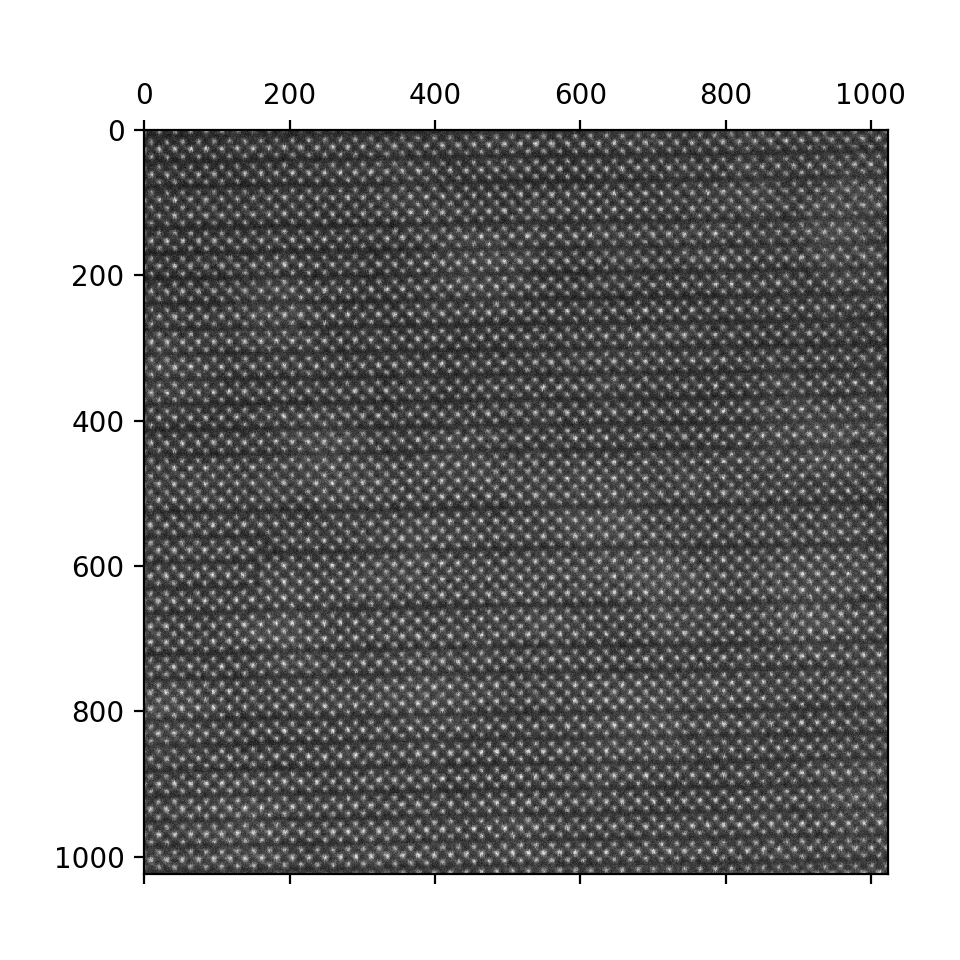

In [5]:
plt.matshow(im, cmap='gray') # Show the image

# Fourier Peaks
We will use the ReciprocalIndex class to find and mark the peak in the FFT that we are interested in extracting structural information from.

In [6]:
T=pld.ReciprocalIndex(im)

In [7]:
T._initSuperlatticePeaks('q_x','q_y', 'q_arb') 

## Superlattice peaks
The next cell will display an interactive FFT. Here we will click on the Bragg spot we are interested and then refine and store its position, as well as extract the tilt angle of the image. Typically, the 020 Bragg spot will be used for RP fault analysis. In this example image, the location of the peak is at x = 513.2256758235744 and y = 601.2128707453212. You can try finding this peak yourself or simply pick a random bright spot and then uncomment and run the code following T.q_x.refinePeakPositions...

<IPython.core.display.Javascript object>


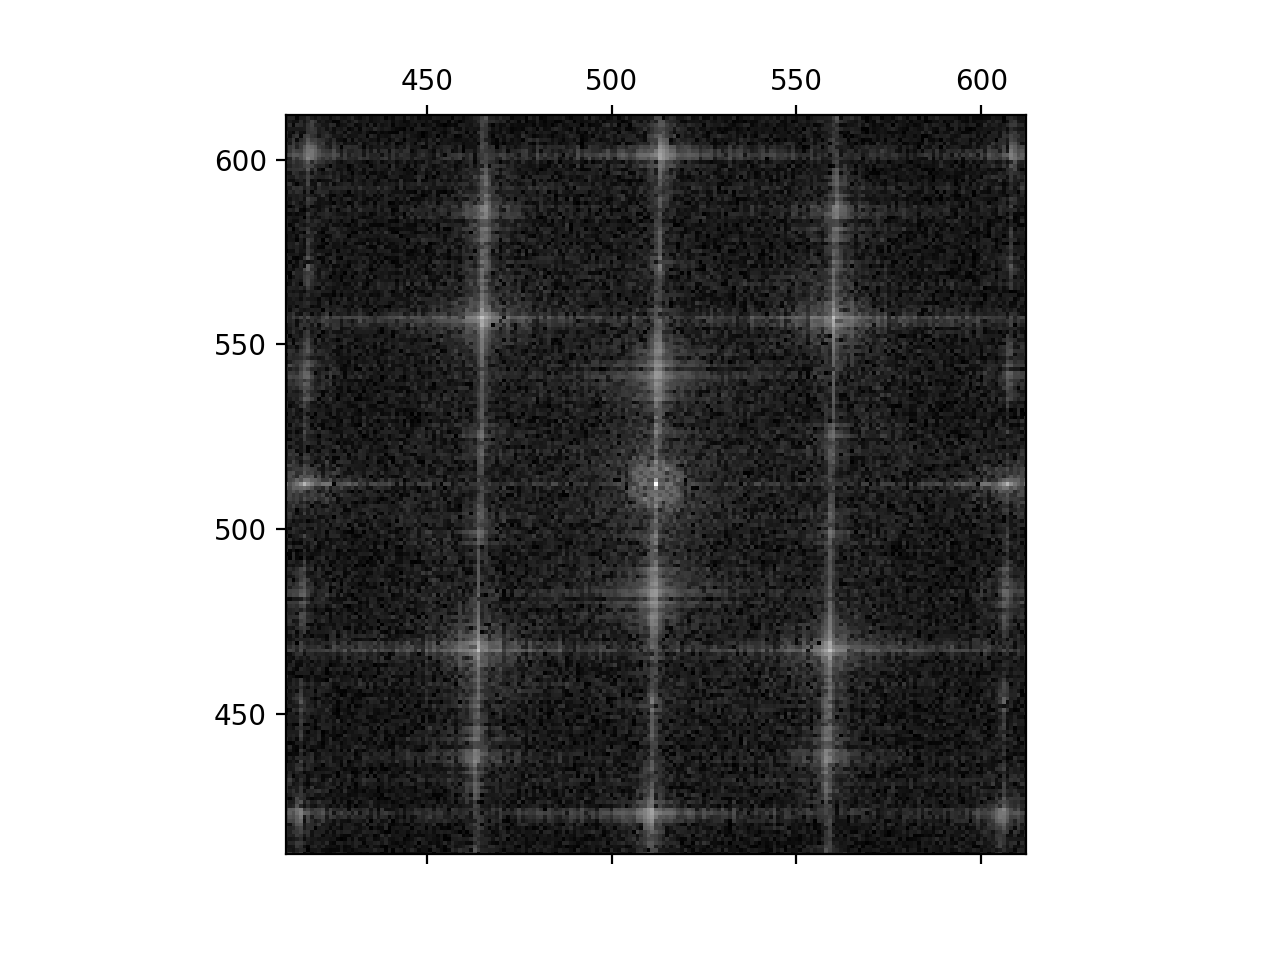

In [8]:
# Click the 020 Bragg spot

T.q_x._clickPeakPosition(zoom=100) # Larger zoom argument -> zoom out; smaller argument -> zoom in


try:
    plt.plot(T.q_x.x[-1],T.q_x.y[-1],'ro') # Plot peaks if any already selectred
except AttributeError:
    pass



In [9]:
T.q_x._appendPeakPosition()  

In [10]:
T.q_x.refinePeakPositions(crop_window=27, track_window=15)

In [11]:
T.q_x.x[-1] = 513.2256758235744
T.q_x.y[-1] = 601.2128707453212

In [12]:
alpha = np.arctan(((im.shape[1]/2)-T.q_x.x[-1])/((im.shape[0]/2)-T.q_x.y[-1])) # Defines angle of sample

<IPython.core.display.Javascript object>


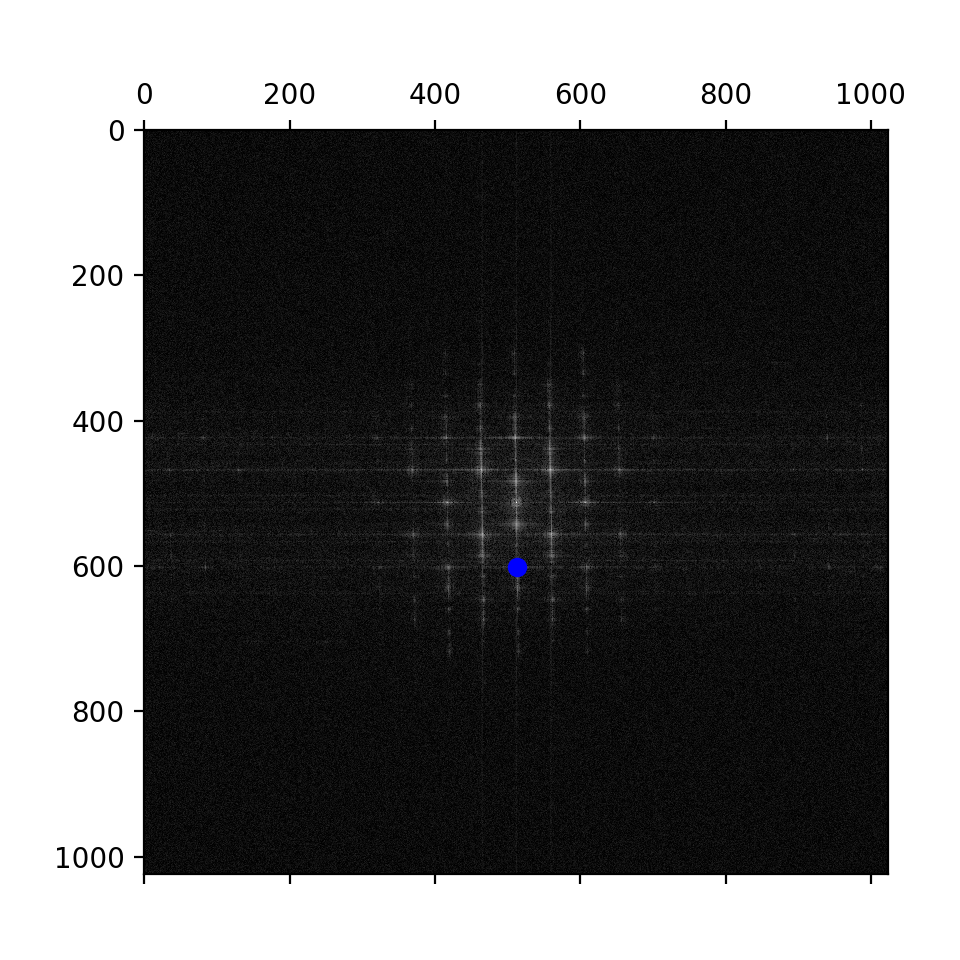

In [13]:
plt.matshow(T.logfft, cmap='gray')
plt.plot(T.q_x.x[-1],T.q_x.y[-1],'bo') # Plot peaks

# Phase

Next we will use a phase lock-in analysis to extract the phase map of the image. We can then obtain from this phase map the local tensile lattice strain by taking its gradient. This procedure is detailed in Goodge, B., El Baggari, I., Hong, S., Wang, Z., Schlom, D., Hwang, H., & Kourkoutis, L. (2022). Disentangling Coexisting Structural Order Through Phase Lock-In Analysis of Atomic-Resolution STEM Data. Microscopy and Microanalysis, 28(2), 404-411. doi:10.1017/S1431927622000125.

This section of the code will take the longest to run, ranging from a few seconds to a few minutes depending on size of image and size of Fourier mask.

Mask size defines real-space coarsening through the below formula:
    
[coarsening (angstrom)] = [lattice spacing (angstrom)] * [distance from center of fft to 010/100 bragg spot] / [mask size]

See the notebook "Phase-mapping_basic-walkthrough" for a method to automatically calculate mask size from desired coarsening

Typically a coarseneing of around 12 works for registered images, but as field of view becomes larger you will need lower resolution

If you select too small of a mask size, it may not cover the entire bragg spot and you will not get any sort of useful data
If the mask is too large, then you will get an image that is too high resolution and includes a lot of noise 
see Goodge, et al. Microscopy and Microanalysis 28 (2), 404-411 (2022) for more details on choosing mask size

In [ ]:
sigma=25. # Mask size

In [15]:
i,label=-1,'020' #Sets fourier point and assigned it a label that can be used in filenaming 
r_dummy= T.Fourier.fourierFilter(T.q_x.x[i],T.q_x.y[i], sigma=sigma)
r=T.Fourier.phaseLockin(T.q_x.x[i],T.q_x.y[i], sigma_x=sigma, sigma_y=sigma)
phase_q_x=(r[0])%(2*np.pi)

In [16]:
T.Fourier.phase=(T.Fourier.phase-np.pi/2.)%(2.*np.pi) # Generates phase map

In [17]:
kx=T.q_x.x[i]-T.im.shape[0]/2. # Generates wavevectors
ky=T.q_x.y[i]-T.im.shape[1]/2.

In [18]:
T.Fourier.get_eps(ky,kx, phase_shift=np.pi/17.) # Generates strain map

In [19]:
eps_xc,eps_xs = T.Fourier.eps_compression.copy(), T.Fourier.eps_shear.copy()

<IPython.core.display.Javascript object>


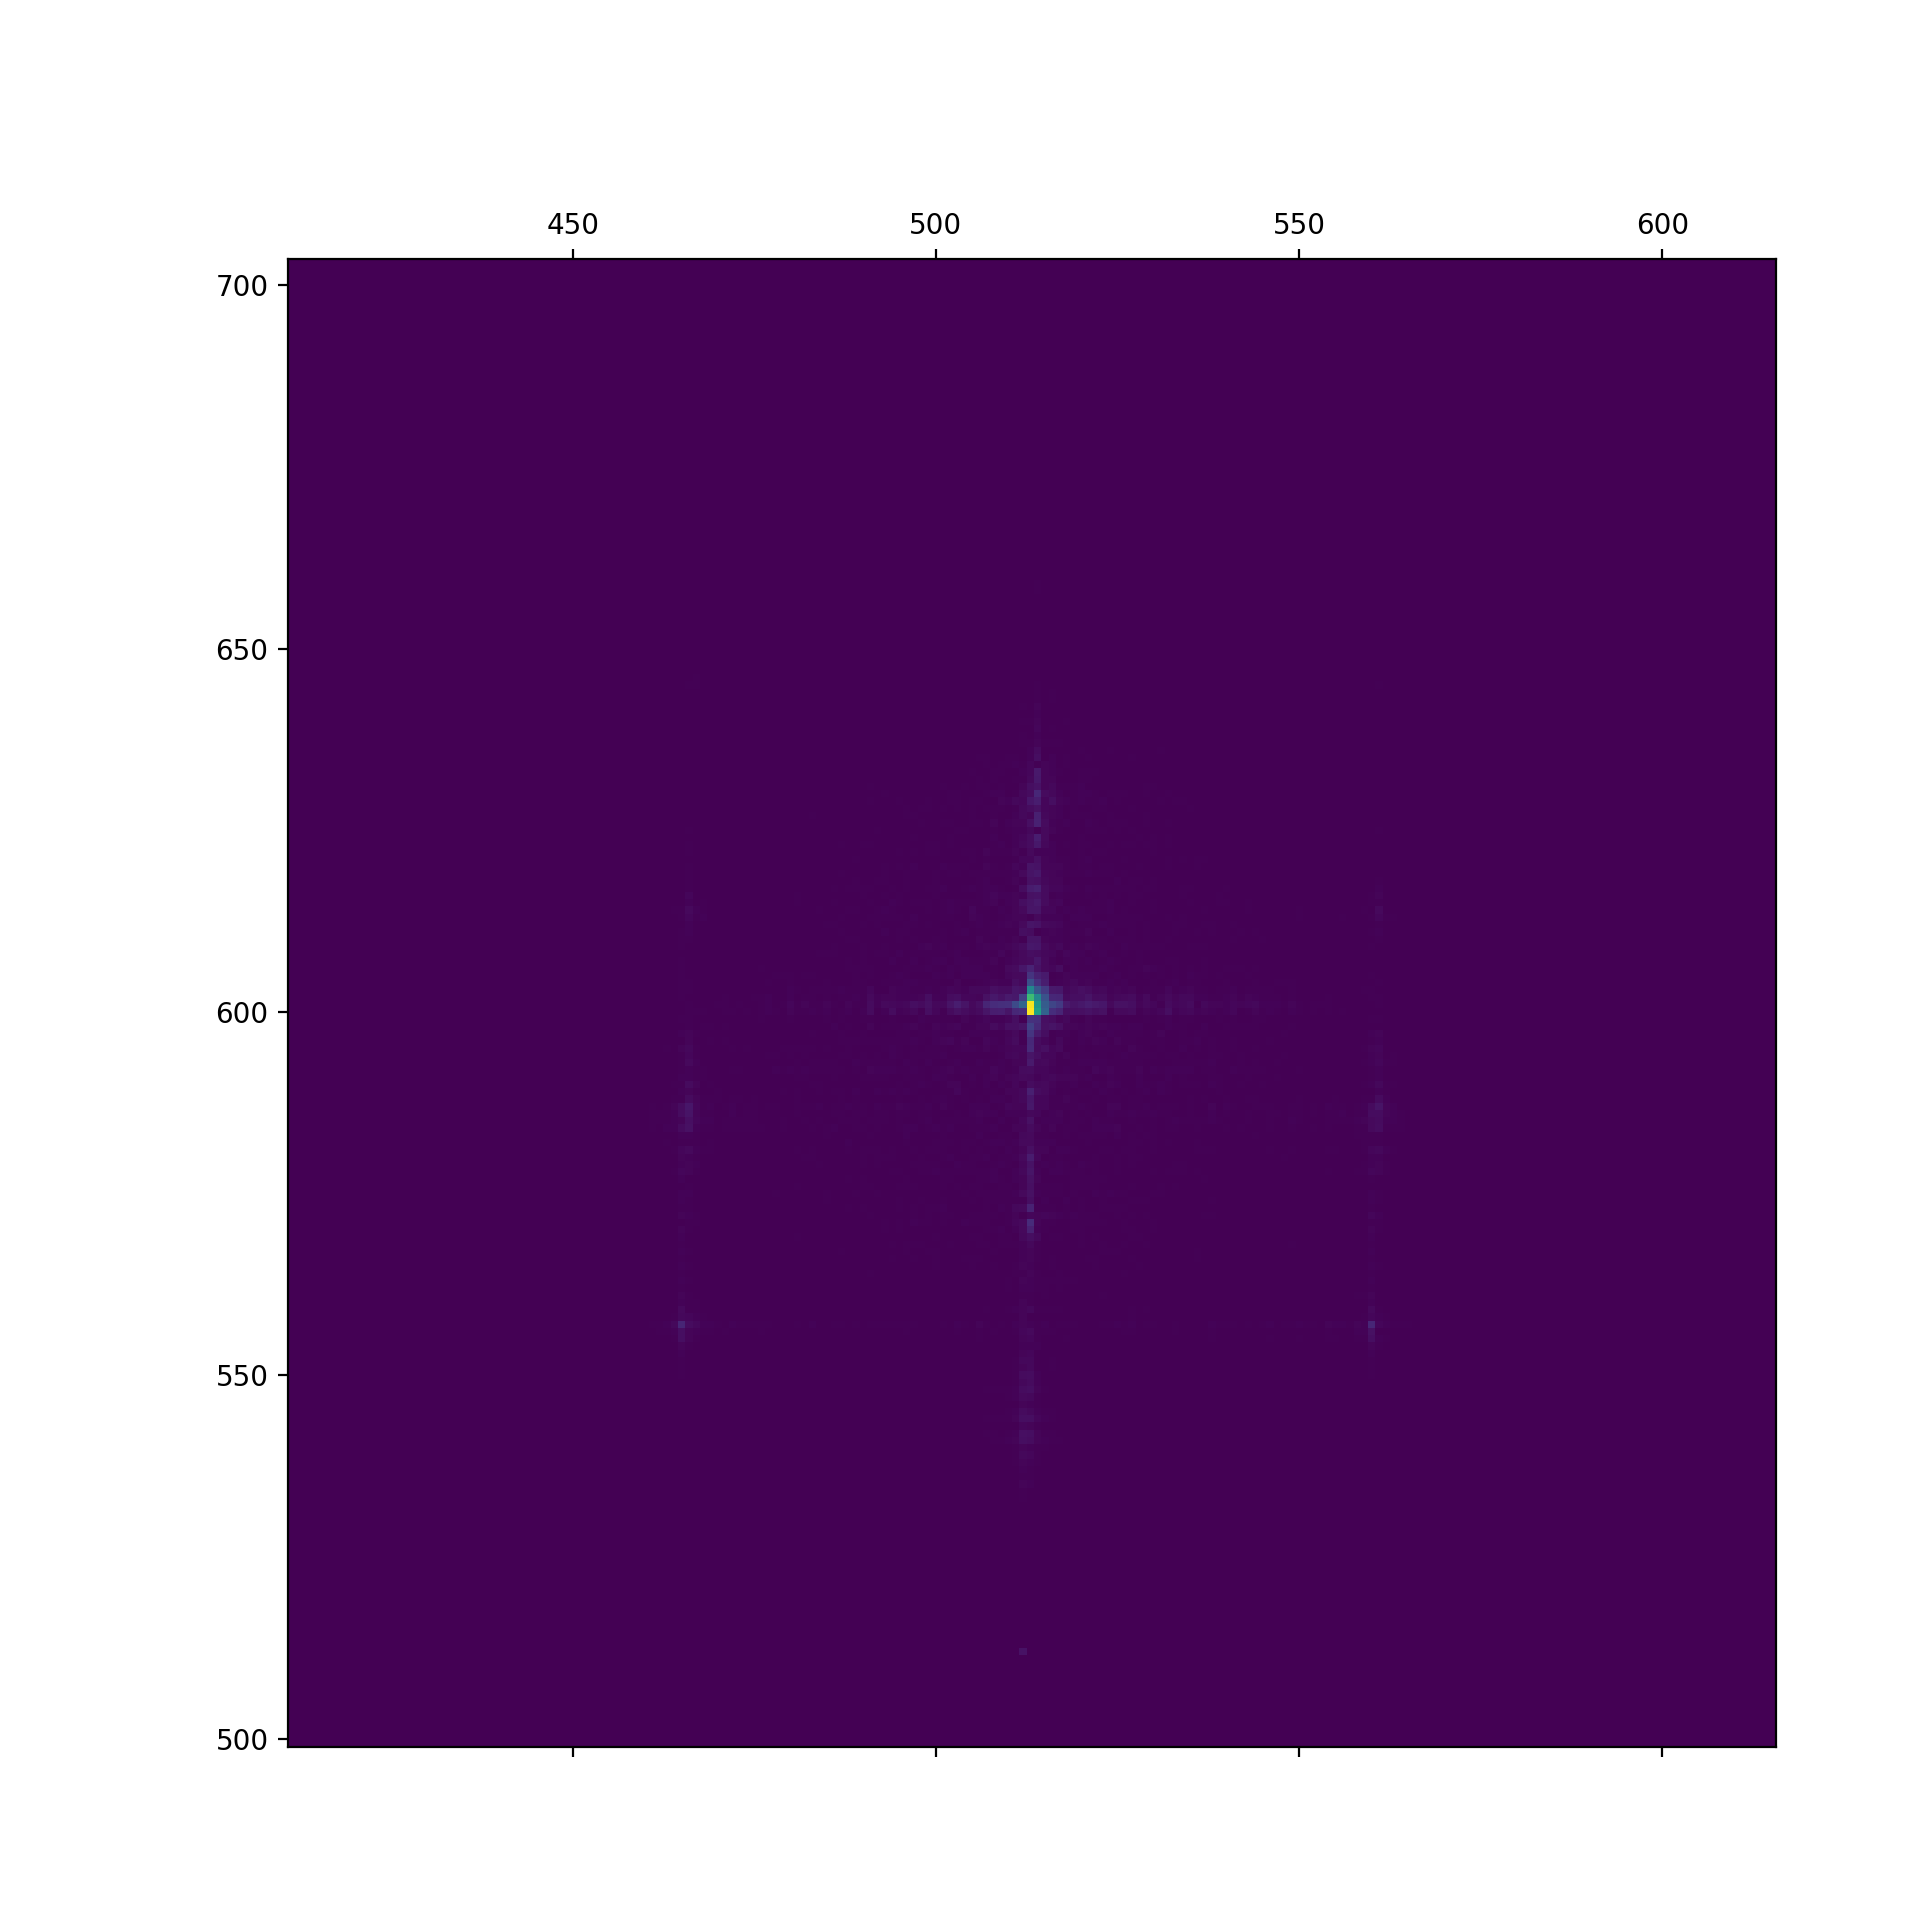

(498.8128707453212, 703.6128707453212)

In [20]:
plt.matshow(np.abs(r_dummy[1])) # Shows Fourier component

# To zoom in on masked peak, uncomment following lines.

plt.xlim((T.q_x.x[i]-im.shape[0]/10, T.q_x.x[i]+im.shape[0]/10))
plt.ylim((T.q_x.y[i]-im.shape[1]/10, T.q_x.y[i]+im.shape[1]/10))

# Strain
Now the phase lock-in analysis has been completed and storied in a number of variables above. We are interested in the local lattice tensile strain which is shown below. 

<IPython.core.display.Javascript object>


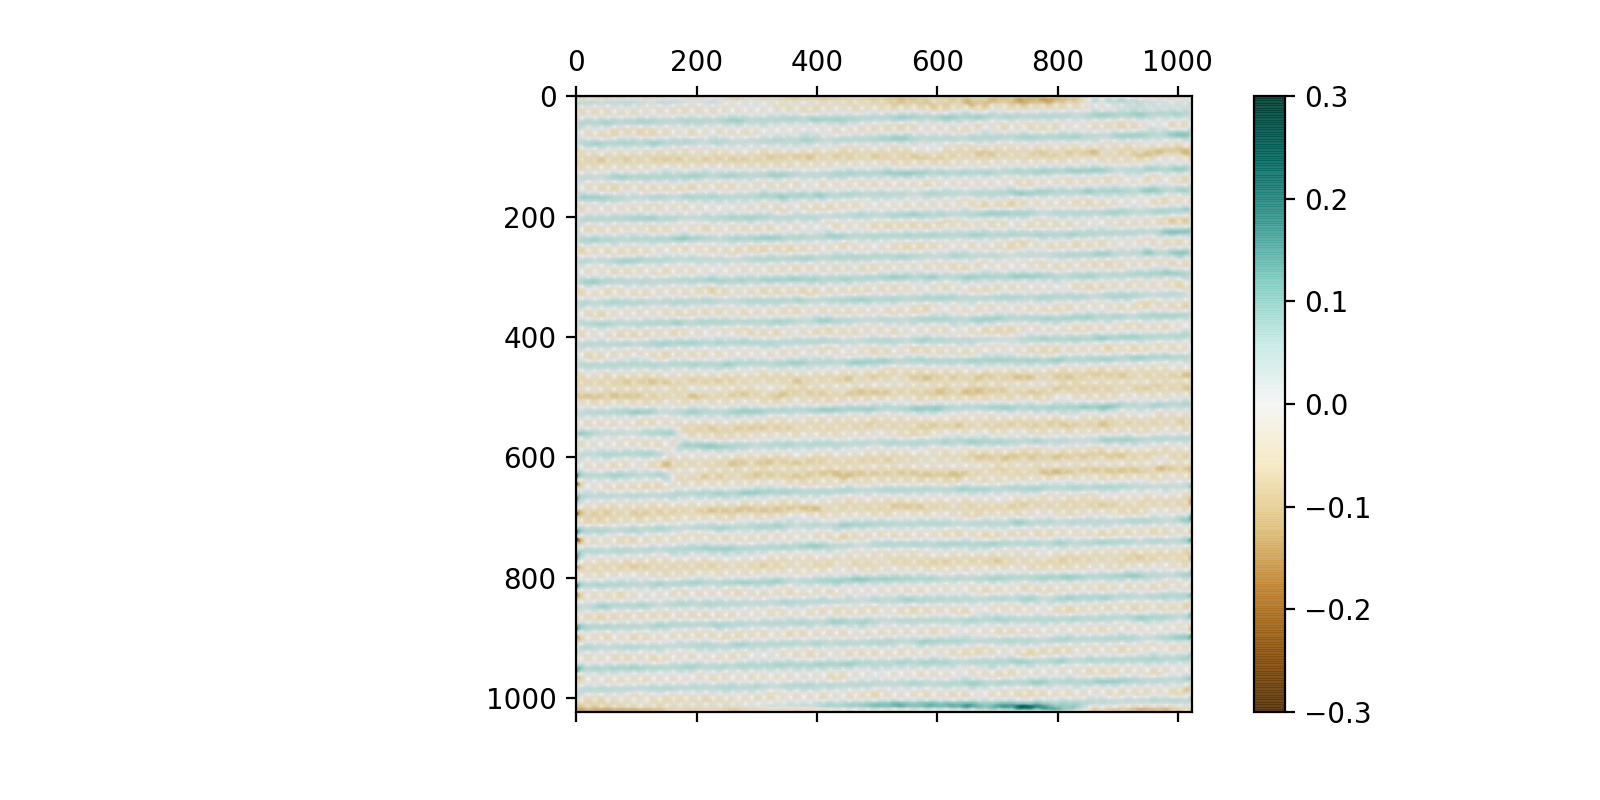

In [21]:
fig, ax =plt.subplots(1, figsize=(8,4), sharex=True, sharey=True)


c_im00=ax.matshow(T.im, cmap='gray')
c_im0 = ax.matshow(median_filter(eps_xc,size=5), vmin=-0.3, vmax=0.3, cmap='BrBG', alpha = 0.9)

plt.colorbar(c_im0)

From this strain map, the most important detail will be to find the weakest RP fault that we want to qualify as a true RP fault to determine the threshold. There is no exact way to find what the threshold should be. Essentially, however, the threshold classifies what the minimum tensile lattice strain must be for a RP fault to "count." As detailed in this program's associated publication, this becomes rather important when dealing with images that contain regions of mixed projection. In a perfectly ordered crystal, the analysis will not be too sensitive to the threshold, however in less "clean" samples, some precision must be taken here.

Here, we choose the threshold to be 0.02.

In [22]:
threshold = 0.02 # The weakest strain that you want to consider as a boundary. 
                 # I recommend finding a solid boundary, and then finding the strain on the edge of it.
                 # This may take some playing around with. 
        
threshold_og = threshold

# Mapping
The next cell will take the actual line cuts in the image. It is all fairly automated, however there are a few parameters that can be changed. 

The spacing variable can be changed top determine the horizontal sampling rate.

The x0, y0, y1, x1 variables can be changed to specify the exact region of interest

The linewidth argument in the sk.measure.profile_line can be modified, depending on sample sensitivity can range from 1 to int(1/px_scale)

The arguments in the sp.signal.find_peaks can also be modified. The default is set to a minimum spacing beteeen peaks of one full pc lattice unit and a width of 1/4 of a pc lattice unit.


In [23]:
peak_coords = []

px_scale = np.sqrt((T.q_x.x[-1]-im.shape[1]/2)**2+(T.q_x.y[-1]-im.shape[0]/2)**2)/(2*im.shape[0]) # Defines conversion factor for pixels to local n

spacing = 1 # Sampling rate (e.g. spacing = 5 samples every 5 atomic columns)

scale = int(spacing/px_scale) 

# May want to not look at far ends of images due to edge effects, depends on mapping
left_edge = 10 # Determines distance from left edge of image to stop 
right_edge = 0 # Determines distance from right edge of image to start

for x0 in range(int((int(len(eps_xc[0])-len(eps_xc[1])*np.tan(alpha))))-right_edge): 
    if x0%scale == 0:
        x0 = x0 + left_edge # Set initial x coordinate
        y0 = 10 # Set initial y coordinate
        y1 = (eps_xc.shape[0])-15 # Set final y coordinate
        x1 = int((y1-y0)*np.tan(alpha)+x0) # Set final x coordinate
    
        z = sk.measure.profile_line(image = eps_xc, src = [y0, x0], dst = [y1, x1], linewidth = int(1/(px_scale))) # Takes integrated width line profile
        
        num = int(np.sqrt((y1-y0)**2+(x1-x0)**2)) # Find number of samples
        x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num) 
        
        nums = list(range(num))
        xcoords = []
        ycoords = []
        

        # Converts indices in line profile into x and y coordinates of image
        for i in nums:
            xcoords.append((float(i))*(np.sin(alpha))+(x0))
            ycoords.append((float(i))*(np.cos(alpha))+(y0))

        z[z< threshold_og] = 0 # thresholds the data

        
                
        #Width parameter may need to be changed based on the mask size and thresholding.
        #For troubleshooting, somewhere between 1/(2*px_scale) and 1/(10*px_scale) always seems to work
        
        # For sp.signal.find_peaks:
        # z is the interpolated data (the line cut)
        # distance is the minimum distance required before the next peak is counted
        # width is the minimum width required of a peak (if threshold is too low, the width may need to be smaller)
           
        
        peaks, _ = sp.signal.find_peaks(z, distance = 1/(px_scale), width = 1/(4*px_scale)) # Find peaks
      
    
        col = [] # Creates empty array to store this line profile's peaks
        
        for j in range(len(peaks)):
            col.append([int(((float(peaks[j]))*(np.sin(alpha))+(x0))), int((float(peaks[j]))*(np.cos(alpha))+(y0))])
        
        if len(col) >=2 : # If there are two coordinates (i.e. one complete RP)
            peak_coords.append(col)
            
og_peak_coords = copy.deepcopy(peak_coords)




The next cell contains a preliminary (unlabeled, uncolorcoded) version of the real space mapping of local n.


<IPython.core.display.Javascript object>


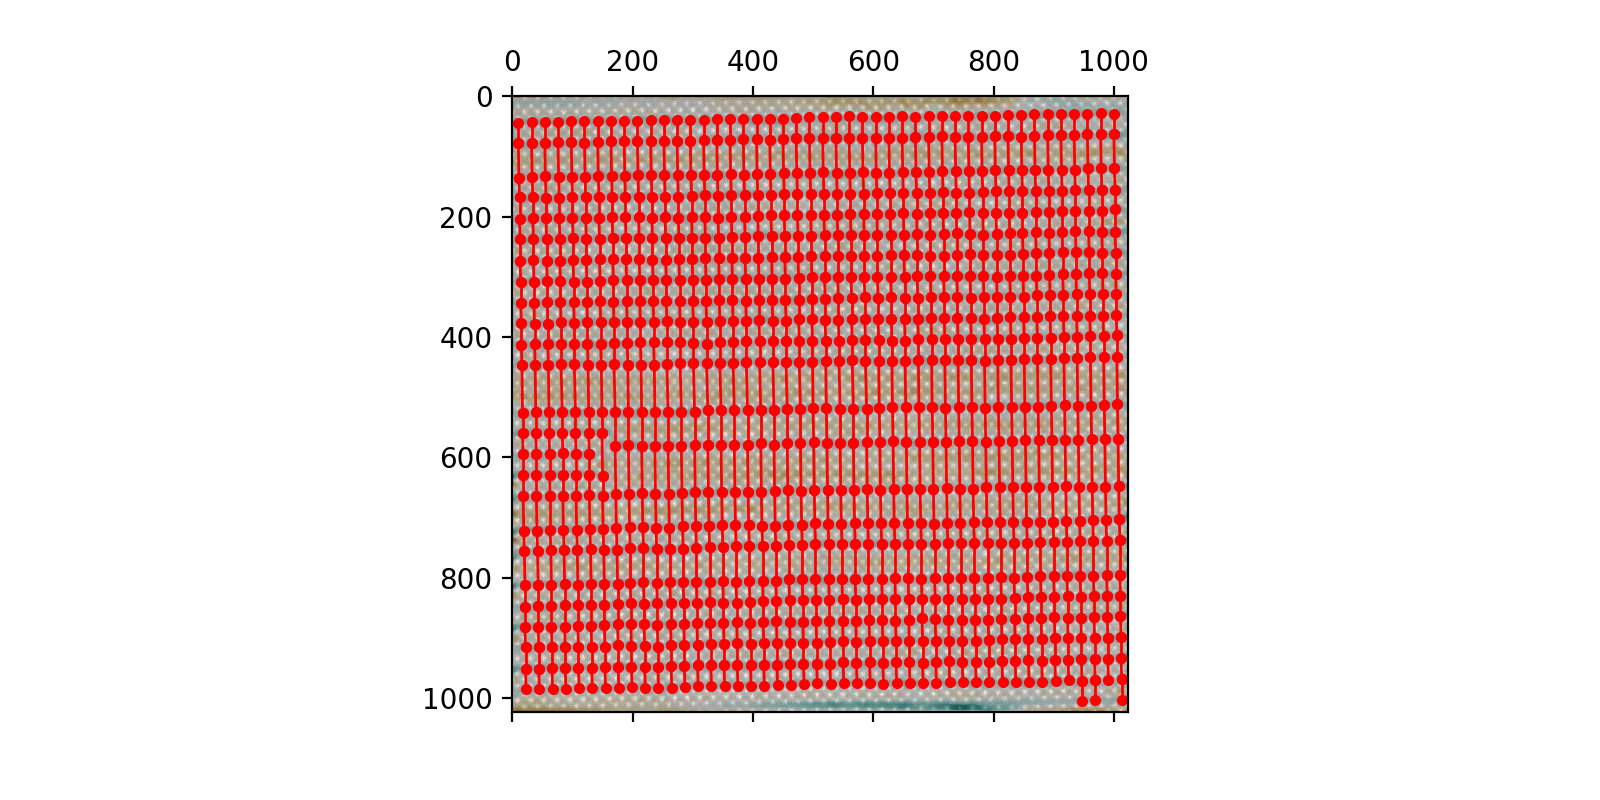

In [24]:
fig, ax =plt.subplots(1, figsize=(8,4), sharex=True, sharey=True)

c_im00=ax.matshow(T.im, cmap='gray')
c_im0 = ax.matshow(median_filter(eps_xc,size=10), vmin=-0.25, vmax=0.25, cmap='BrBG', alpha = 0.6)

for i in range(len(peak_coords)):
        for j in range(len(peak_coords[i])-1):
           
            px_dist = np.sqrt((peak_coords[i][j][0]-peak_coords[i][j+1][0])**2+(peak_coords[i][j][1]-peak_coords[i][j+1][1])**2) # Distance between peaks in pixels
            almost_uc_dist = px_dist * px_scale # Converts to rough estimate of number of unit cells
            uc_dist = int(np.floor(almost_uc_dist)) # Floors value to obtain integer n phase
        
            #print('n = ' + str(uc_dist)+ ', coords = (' + str(peak_coords[i][j][0]) + ', ' +  str(peak_coords[i][j][1]) + '), ('+ str(peak_coords[i][j+1][0]) + ', ' +  str(peak_coords[i][j+1][1]) + ')')
           
            ax.plot([peak_coords[i][j][0], peak_coords[i][j+1][0]], [peak_coords[i][j][1], peak_coords[i][j+1][1]], 'ro-' ,linewidth = 1, markersize = 3) # Initial plot of counts

# Statistical corrections
Next we will want to apply our statistical corrections to ensure that our mapping and count are both accurate. For reasons detailed in the publication, we want to ensure that each of our line cuts "starts" and "ends" on the same RP fault. Thus, in the next cell we will choose a top_cutoff and a bottom_cutoff, which refer to the number (from the top and bottom respectively) fault that we want to count as a start. The topmost appearing RP fault is 0 for top_cutoff, and the bottommost is 0 for bottom_cutoff.

Here, top_cutoff was chosen to be to 0 and 1 (try and look at the map above and see why!).

The cell will loop through a given tolerance, which is up to user specification, and create an acceptable range of starting and ending positions for each line cut, and remove those line cuts that cannot be reduced to these positions.

In [25]:
xcoords = []
ycoords = []
skewed_top = []
skewed_bottom = []

peak_coords_copy = copy.deepcopy(peak_coords)

for i in peak_coords:
    for j in i:
        xcoords.append(j[0])
        ycoords.append(j[1])
        
# top_cutoff and bottom_cutoff define which "lines" you want to start taking data at.
# This is for the purpose of not biasing the data if it is missing a fault.
# Choose the top and bottom that either make the most sense, or maximize the number of data points (have the most line cuts that start and end on those lines)
# Note the tolerance of this lines can be changed, so for example for smaller crystals this tolerance may need to be lower
    # However this also means that small variations in n would be affected, it will go to the next strain line at least tolerance pixels below the top recorded strain line. 

top_cutoff = 0 # RP fault you want to start data at (starting from topmost at 0)
bottom_cutoff = 1  # RP fault you want to stop data at (starting from bottommost at 0)
                  
tolerance = int(1/px_scale) #anything around within 1 pc lattice unit will be good

for x in range(im.shape[1]):
    skewed_top.append([x, int(min(ycoords) + ((xcoords[np.argmin(ycoords)]-x)*np.tan(alpha)))])
    skewed_bottom.append([x, int(max(ycoords)-((-xcoords[np.argmax(ycoords)]+x)*np.tan(alpha)))])
    for i in range(tolerance):
        skewed_top.append([x, int(min(ycoords) + ((xcoords[np.argmin(ycoords)]-x)*np.tan(alpha)))+i])
        skewed_top.append([x, int(min(ycoords) + ((xcoords[np.argmin(ycoords)]-x)*np.tan(alpha)))-i])
        skewed_bottom.append([x, int(max(ycoords)-((-xcoords[np.argmax(ycoords)]+x)*np.tan(alpha)))+i])
        skewed_bottom.append([x, int(max(ycoords)-((-xcoords[np.argmax(ycoords)]+x)*np.tan(alpha)))-i])


count = 0


while count < top_cutoff:
    peak_coords = copy.deepcopy(peak_coords_copy)
    
    for i in range(len(peak_coords)):
 
        if peak_coords[i][0] in skewed_top:
            
            index = peak_coords_copy.index(peak_coords[i])
            peak_coords_copy[index].remove(peak_coords[i][0])
            xcoords.remove(peak_coords[i][0][0])
            ycoords.remove(peak_coords[i][0][1])
    
    skewed_top = []
    
    for x in range(im.shape[1]):
        skewed_top.append([x, int(min(ycoords) + ((xcoords[np.argmin(ycoords)]-x)*np.tan(alpha)))])
        for i in range(tolerance):
            skewed_top.append([x, int(min(ycoords) + ((xcoords[np.argmin(ycoords)]-x)*np.tan(alpha)))+i])
            skewed_top.append([x, int(min(ycoords) + ((xcoords[np.argmin(ycoords)]-x)*np.tan(alpha)))-i])

    
    count = count + 1

count = 0

while count < bottom_cutoff:
    peak_coords = copy.deepcopy(peak_coords_copy)
    
    for i in range(len(peak_coords)):
 
        if peak_coords[i][-1] in skewed_bottom:
            
            index = peak_coords_copy.index(peak_coords[i])
            peak_coords_copy[index].remove(peak_coords[i][-1])
            xcoords.remove(peak_coords[i][-1][0])
            ycoords.remove(peak_coords[i][-1][1])
    
    skewed_bottom = [] 
    
    for x in range(im.shape[1]):
        skewed_bottom.append([x, int(max(ycoords)-((-xcoords[np.argmax(ycoords)]+x)*np.tan(alpha)))])
        for i in range(tolerance):
            skewed_bottom.append([x, int(max(ycoords)-((-xcoords[np.argmax(ycoords)]+x)*np.tan(alpha)))+i])
            skewed_bottom.append([x, int(max(ycoords)-((-xcoords[np.argmax(ycoords)]+x)*np.tan(alpha)))-i])
    
    count = count + 1

peak_coords_copy2 = copy.deepcopy(peak_coords_copy)


for i in range(len(peak_coords_copy2)): # Remove line cuts that don't hit both the new "top and bottom"
    if peak_coords_copy2[i][0] not in skewed_top or peak_coords_copy2[i][-1] not in skewed_bottom:
        peak_coords_copy.remove(peak_coords_copy2[i])

In [26]:
final_coords = []
uc_dists = []


for i in range(len(peak_coords_copy)):
        for j in range(len(peak_coords_copy[i])-1):
            px_dist = np.sqrt((peak_coords_copy[i][j][0]-peak_coords_copy[i][j+1][0])**2+(peak_coords_copy[i][j][1]-peak_coords_copy[i][j+1][1])**2) 
            ang_dist = px_dist * px_scale
            uc_dist = int((np.floor(ang_dist)))
            #print('n = ' + str(uc_dist)+ ', coords = (' + str(peak_coords_copy[i][j][0]) + ', ' +  str(peak_coords_copy[i][j][1]) + '), ('+ str(peak_coords_copy[i][j+1][0]) + ', ' +  str(peak_coords_copy[i][j+1][1]) + ')')
            uc_dists.append(uc_dist)
            final_coords.append([[peak_coords_copy[i][j][0], peak_coords_copy[i][j][1]], [peak_coords_copy[i][j+1][0], peak_coords_copy[i][j+1][1]]])

<IPython.core.display.Javascript object>


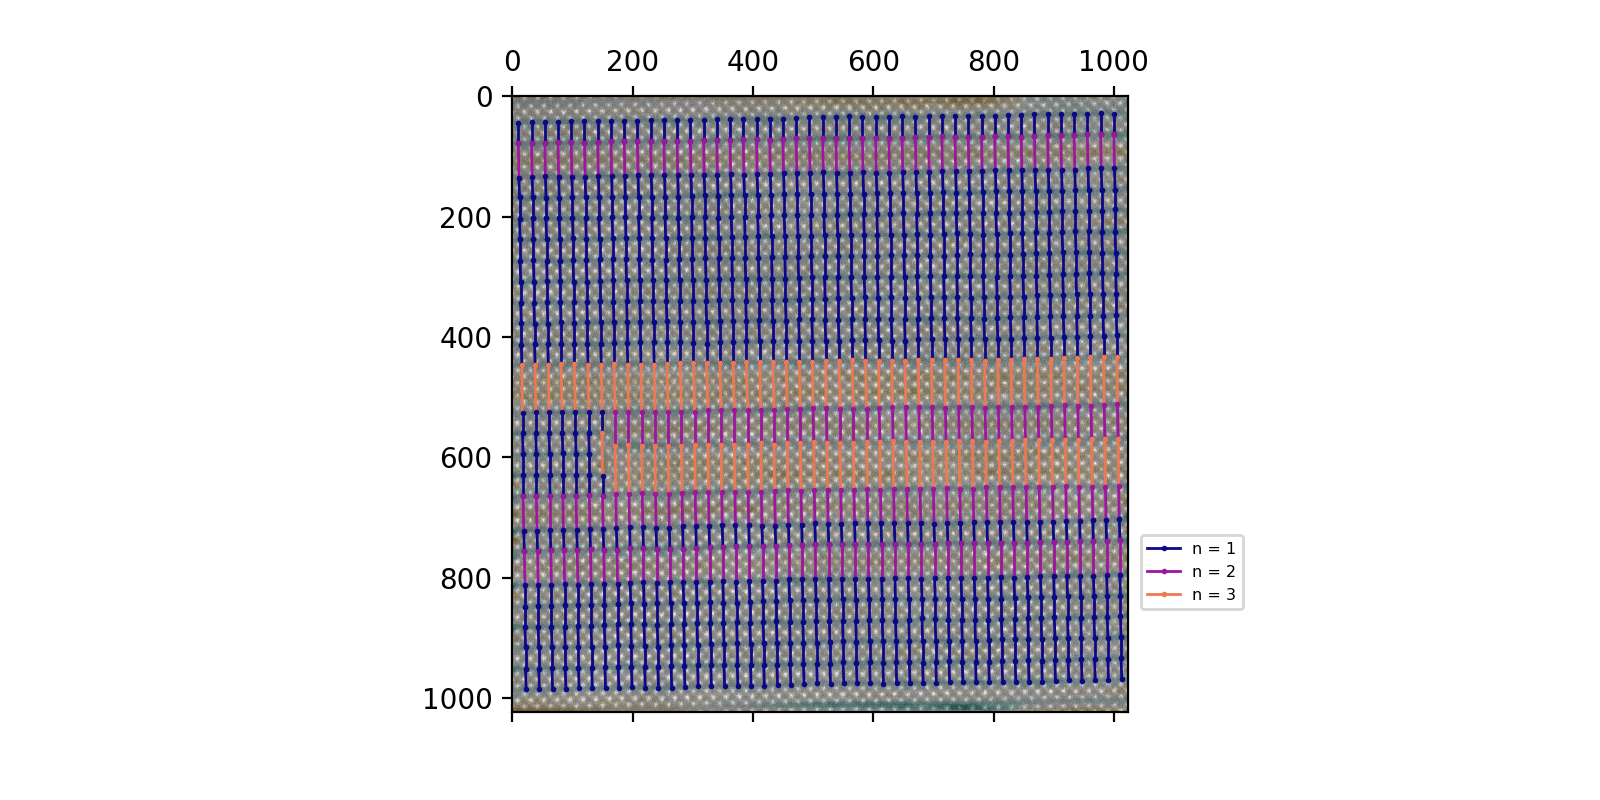

In [27]:
fig, ax =plt.subplots(1, figsize=(8,4), sharex=True, sharey=True)

c_im00=ax.matshow(T.im, cmap='gray')
c_im0 = ax.matshow(median_filter(eps_xc,size=10), vmin=-0.25, vmax=0.25, cmap='BrBG', alpha = 0.4)

cm = plt.get_cmap('plasma')  
uc_in_order = list(set(uc_dists)) # Creates ordered list
count = len(set(uc_dists)) # Number of different n phases

diff = len(set(uc_dists)) + 1
colors = []


for i in range(len(final_coords)):
    this_color = (uc_in_order.index(uc_dists[i]))*256/(diff-1)
    color = cm(int(this_color))
    colors.append(color)
    ax.plot([final_coords[i][0][0], final_coords[i][1][0]], [final_coords[i][0][1], final_coords[i][1][1]], color = color, marker = 'o' ,linewidth = 1, markersize = 1, label ='n = ' + str(uc_dists[i]))
        
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
ax.legend(handout, lablout, fontsize = 'xx-small', bbox_to_anchor=(1.2,0.3))

# Minor tweaking
The above map shows the distribution of local n with the statistical corrections applied. However, in images that may have very unclean regions, it could be necessary to make some small adjustments if the RP faults are unclear, which would rely on an understanding of the material being looked at. Typically, if you cannot tell by eye if a given region contains an RP fault, the program will not always interpret it "correctly". Thus, if minor adjustments need to be made, or certain n should not be counted due to this ambiguity, the next cell provides a method of doing that.

This should mostly be used when a certain n count clearly appears to be a certain n, but has been interpreted differently. This can be due to minor rounding issues if the RP faults are not clean in the strain map. For more drastic issues, this is not the route to take. If the mapping appears very off, or there are many n to fix, then the best solution would be to play with the parameters such as mask size.

In [28]:
uc_dists_edited = uc_dists.copy() # Makes copy of n to be edited if small errors occur

# If certain n must be edited but the error appears to not be systematic (i.e. only here and there n is 
# off by ~1), then the list of n can be printed and the associated uc_dist index can be manually modified.
# To remove a given n, set the value corresponding to its index equal to 0.

# All of the n can be found by uncommenting the following lines:

# i = 0
# for coords in final_coords:
#         print(" Index " + str(i) + ": n = " + str(uc_dists[i]) + " with starting, ending coordinates " + str(coords))
#         i = i + 1


uc_in_order = list(set(uc_dists_edited)) 
count = len(set(uc_dists_edited))

# This won't change the mapping, just the quantitative results. If the mapping seems off, 
# try playing around with other parameters first, then as last result you can edit 
# entries of final_coords, with a bit of effort.

## Final results
These final two cells reveal the ultimate goal of the program, a both qualitative and quantitative analysis of RP samples. Firstly, we have the qualitative in the real-space mapping of local n overlaid onto the STEM image and strain map. Finally, we have the quantiative bar chart showing the various n and their associated counts. This is not the only way data can be displayed, as these values and maps can be analyzed further and displayed in a manner that reveals insight onto the sample.  

<IPython.core.display.Javascript object>


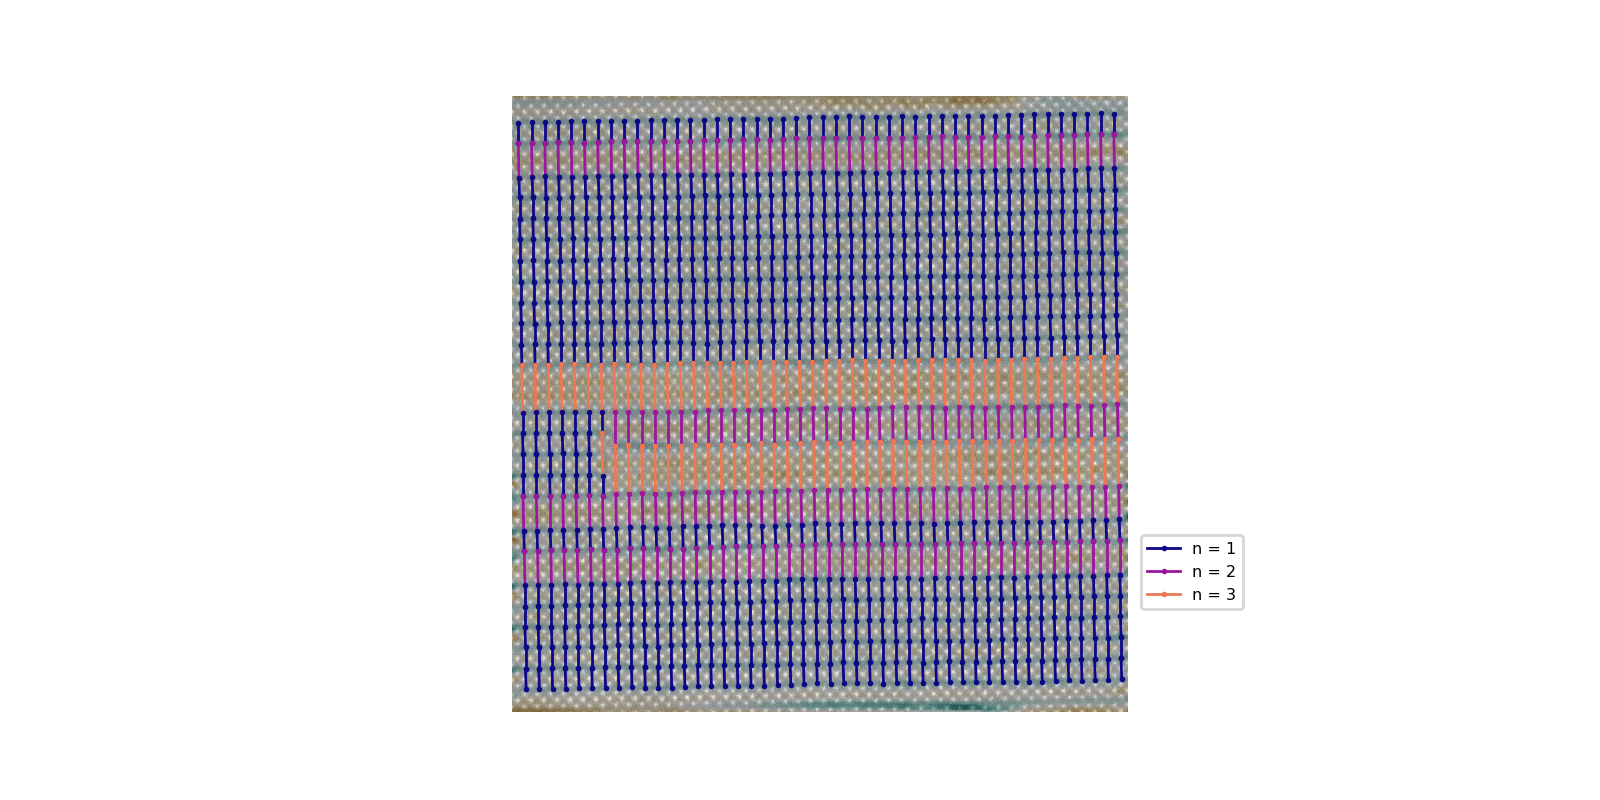

(-0.5, 1023.5, 1023.5, -0.5)

In [29]:
fig, ax =plt.subplots(1, figsize=(8,4), sharex=True, sharey=True)

c_im00=ax.matshow(T.im, cmap='gray')
c_im0 = ax.matshow(median_filter(eps_xc,size=10), vmin=-0.25, vmax=0.25, cmap='BrBG', alpha = 0.5)

diff = len(set(uc_dists_edited)) + 1



cm = plt.get_cmap('plasma')  
colors = []


for i in range(len(final_coords)):
    if uc_dists_edited[i] != 0:
        this_color = (uc_in_order.index(uc_dists[i]))*256/(diff-1)
        color = cm(int(this_color))
        if colors.count(color) == 0:
            colors.append(color)
        ax.plot([final_coords[i][0][0], final_coords[i][1][0]], [final_coords[i][0][1], final_coords[i][1][1]], color = color, marker = 'o' ,linewidth = 1, markersize = 1, label ='n = ' + str(uc_dists_edited[i]))


hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
ax.legend(handout, lablout, fontsize = 'xx-small', bbox_to_anchor=(1.2,0.3))

ax.axis("off")

<IPython.core.display.Javascript object>


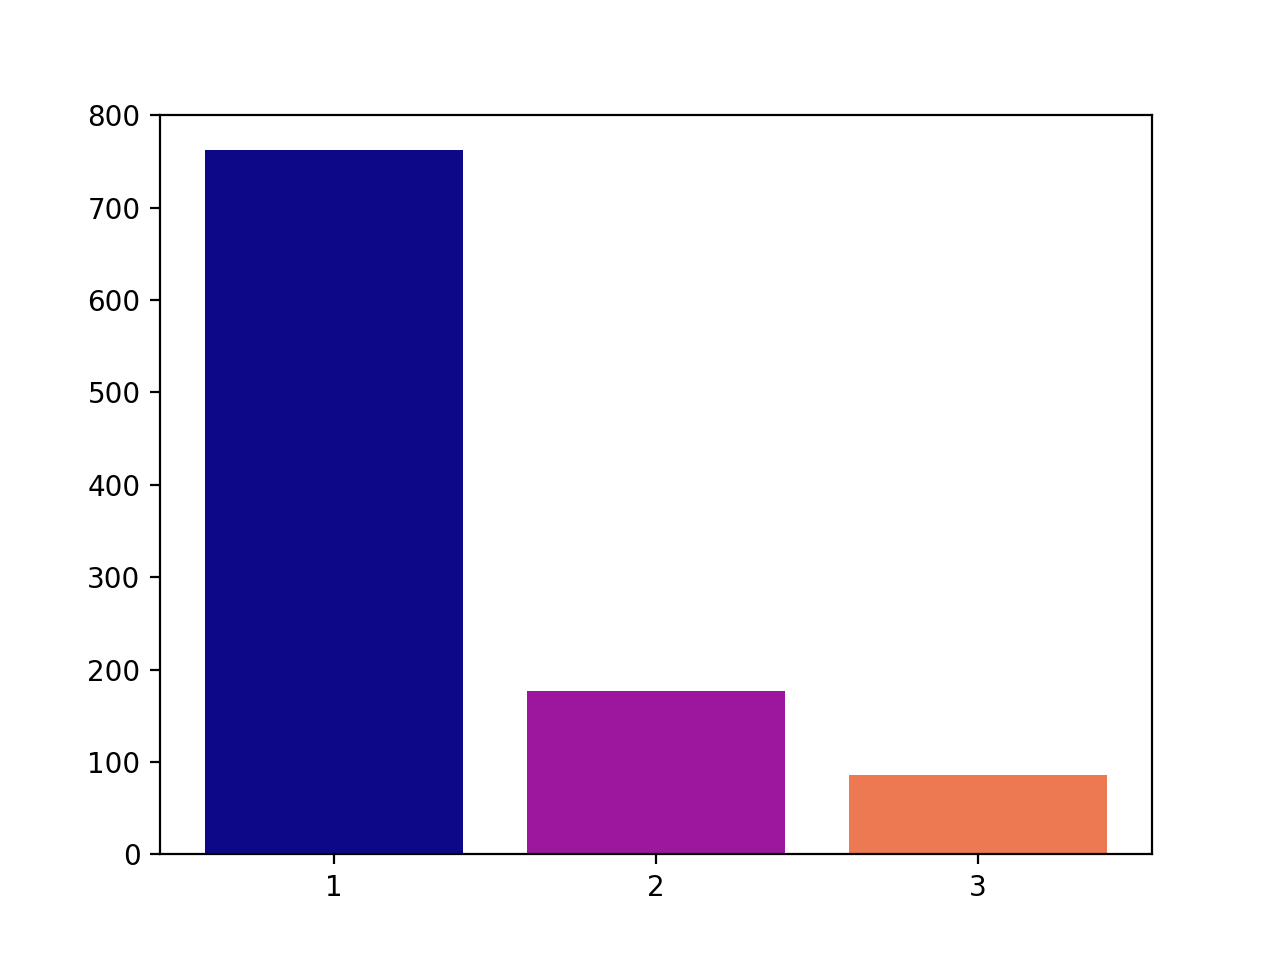

[1 2 3]
[762 177  86]


In [30]:
fig, ax = plt.subplots(nrows=1)

while uc_dists_edited.count(0) > 0:
    uc_dists_edited.remove(0)
    
    
u, counts = np.unique(uc_dists_edited, return_counts=True)
print(u)
print(counts) 

for i in range(len(final_coords)):
    if uc_dists_edited[i] != 0:
        this_color = (uc_in_order.index(uc_dists[i]))*256/(diff-1)

plt.bar(np.arange(len(u)), counts, color = colors)
plt.xticks(np.arange(len(u)), u)
plt.show()